In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import seaborn as sns

# === 1. Load data (already pre-cleaned) ===
df = pd.read_csv("data2.csv")

# Identify blocks (4 columns each: Load, displacement, stress, strain)
subheaders = df.iloc[0].astype(str).str.strip().str.lower().tolist()
blocks = []
i = 0
while i < len(df.columns):
    cols = df.columns[i:i+4]
    subs = subheaders[i:i+4]
    mapping = dict(zip(subs, cols))
    name = cols[0]
    blocks.append({"name": name, "mapping": mapping})
    i += 4

data = df.iloc[1:].reset_index(drop=True)

# === 2. Function to compute modulus ===
def compute_modulus(strain, stress):
    mask = np.isfinite(strain) & np.isfinite(stress) & (strain >= 0) & (stress >= 0)
    s_strain, s_stress = strain[mask], stress[mask]
    if len(s_strain) < 10: return np.nan, np.nan
    # Use 0–15% strain region
    k = max(20, int(0.15*len(s_strain)))
    idx = np.argsort(s_strain)[:k]
    x, y = s_strain[idx].reshape(-1,1), s_stress[idx]
    lr = LinearRegression().fit(x,y)
    y_pred = lr.predict(x)
    r2 = r2_score(y,y_pred)
    return lr.coef_[0], r2

results = []
for blk in blocks:
    if "stress" not in blk["mapping"]: continue
    stress = pd.to_numeric(data[blk["mapping"]["stress"]], errors="coerce")
    strain = pd.to_numeric(data[blk["mapping"]["strain"]], errors="coerce")
    slope, r2 = compute_modulus(strain.values, stress.values)
    results.append({"Group": blk["name"], "Elastic_Modulus": slope, "R2": r2})

res_df = pd.DataFrame(results)
res_df.to_csv("elastic_modulus_results.csv", index=False)
print(res_df)

# === 3. ML on modulus values ===
# Example: if you have density or type info, add as features
res_df["Density"] = [40,50,40,50]   # dummy example
res_df["Type"] = ["Lidinoid","Lidinoid","FCC","FCC"]

X = pd.get_dummies(res_df[["Density","Type"]], drop_first=True)
y = res_df["Elastic_Modulus"]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

models = {
    "Linear": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=200,random_state=42),
    "GBR": GradientBoostingRegressor(random_state=42)
}

for name, model in models.items():
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
  
 

  


          Group  Elastic_Modulus        R2
0  Lidinoid 40%       143.321935  0.967401
1  Lidinoid 50%        59.584534  0.928744
2       FCC 40%       102.392606  0.978035
3       FCC 50%        96.897501  0.949835


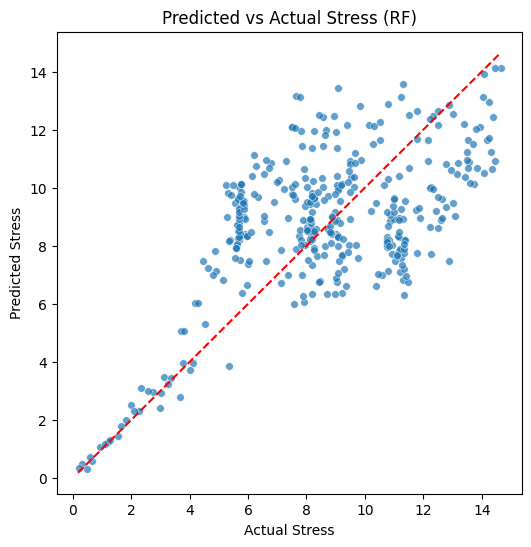

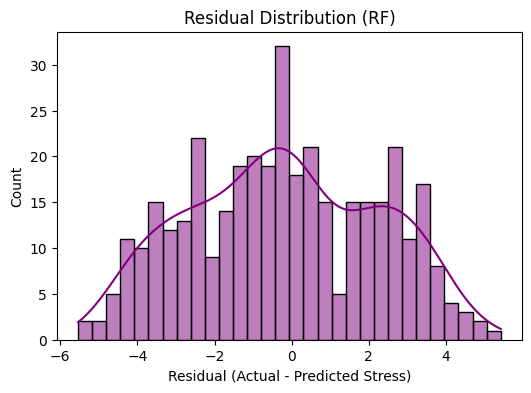

In [2]:
# === Rebuild dataset with stress-strain ===
all_data = []

for blk in blocks:
    if "stress" not in blk["mapping"]: continue
    stress = pd.to_numeric(data[blk["mapping"]["stress"]], errors="coerce")
    strain = pd.to_numeric(data[blk["mapping"]["strain"]], errors="coerce")

    temp_df = pd.DataFrame({
        "Strain": strain,
        "Stress": stress,
        "Group": blk["name"]
    })
    all_data.append(temp_df)

stress_df = pd.concat(all_data, ignore_index=True).dropna()

# Add dummy features (replace with your real metadata if available)
stress_df["Density"] = np.random.choice([40,50], size=len(stress_df))  
stress_df["Type"] = np.random.choice(["Lidinoid","FCC"], size=len(stress_df))

# === ML Prediction of Stress ===
X = pd.get_dummies(stress_df[["Strain","Density","Type"]], drop_first=True)
y = stress_df["Stress"]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)


# === Plots ===
# Predicted vs Actual Stress
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, s=30, alpha=0.7)
plt.plot([y.min(),y.max()],[y.min(),y.max()],'--r')
plt.xlabel("Actual Stress")
plt.ylabel("Predicted Stress")
plt.title("Predicted vs Actual Stress (RF)")
plt.savefig("alldatapoints stress.png", dpi=600, bbox_inches="tight")  # high resolution
plt.show()

# Residuals plot
residuals = y_test - y_pred
plt.figure(figsize=(6,4))
sns.histplot(residuals, bins=30, kde=True, color="purple")
plt.title("Residual Distribution (RF)")
plt.xlabel("Residual (Actual - Predicted Stress)")
plt.savefig("alldatapoints residual.png", dpi=600, bbox_inches="tight")  # high resolution
plt.show()



Points within ±0.5 stress error: 65
Points outside ±0.5 stress error: 311


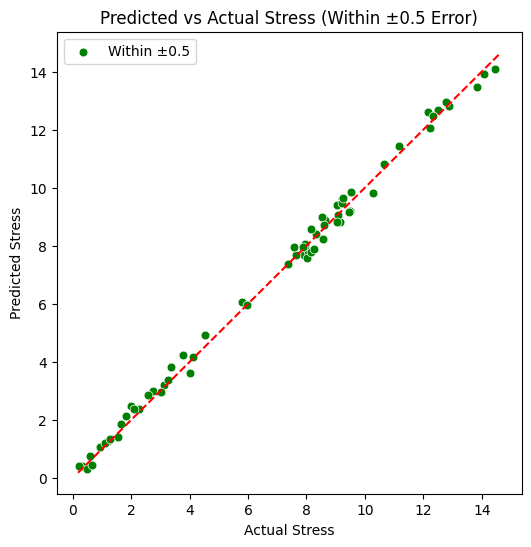

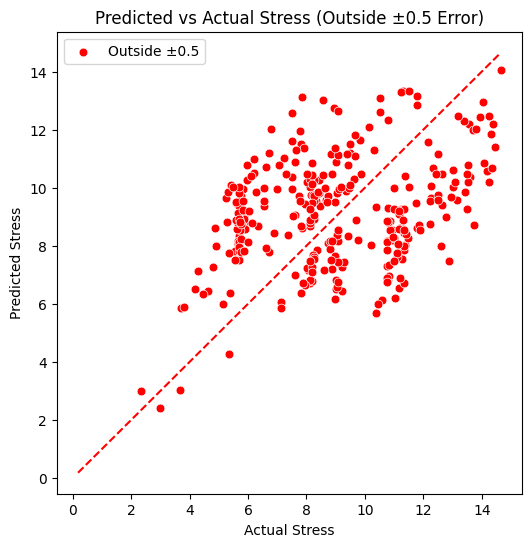

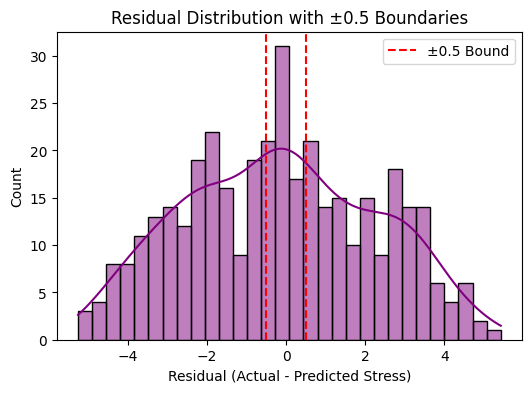

In [9]:
# === Residuals (error) ===
residuals = y_test - y_pred

# ✅ Filter points within ±0.5 stress error
within_05 = abs(residuals) <= 0.5
outside_05 = abs(residuals) > 0.5

print(f"Points within ±0.5 stress error: {within_05.sum()}")
print(f"Points outside ±0.5 stress error: {outside_05.sum()}")

# === Plot: Predicted vs Actual (within ±0.5 only) ===
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test[within_05], y=y_pred[within_05], color="green", s=40, label="Within ±0.5")
plt.plot([y.min(),y.max()],[y.min(),y.max()],'--r')
plt.xlabel("Actual Stress")
plt.ylabel("Predicted Stress")
plt.title("Predicted vs Actual Stress (Within ±0.5 Error)")
plt.legend()
plt.show()

# === Plot: Predicted vs Actual (outside ±0.5 only) ===
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test[outside_05], y=y_pred[outside_05], color="red", s=40, label="Outside ±0.5")
plt.plot([y.min(),y.max()],[y.min(),y.max()],'--r')
plt.xlabel("Actual Stress")
plt.ylabel("Predicted Stress")
plt.title("Predicted vs Actual Stress (Outside ±0.5 Error)")
plt.legend()
plt.show()

# === Residual Distribution (highlight ±0.5 zone) ===
plt.figure(figsize=(6,4))
sns.histplot(residuals, bins=30, kde=True, color="purple")
plt.axvline(-0.5, color="red", linestyle="--", label="±0.5 Bound")
plt.axvline(0.5, color="red", linestyle="--")
plt.title("Residual Distribution with ±0.5 Boundaries")
plt.xlabel("Residual (Actual - Predicted Stress)")
plt.legend()
plt.savefig("alldatapoints residual0.5.png", dpi=600, bbox_inches="tight")  # high resolution
plt.show()


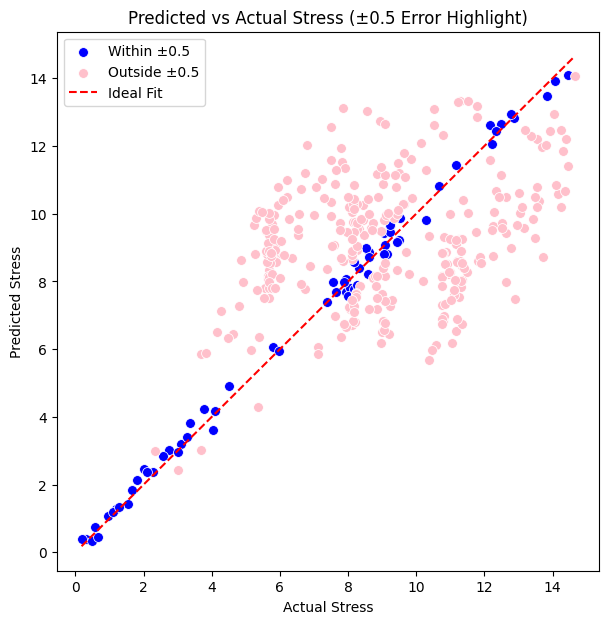

In [10]:
# === Residuals (error) ===
residuals = y_test - y_pred

# Mask for ±0.5
within_05 = abs(residuals) <= 0.5
outside_05 = abs(residuals) > 0.5

# === Combined Plot: Predicted vs Actual with ±0.5 classification ===
plt.figure(figsize=(7,7))

# Points within ±0.5
sns.scatterplot(
    x=y_test[within_05],
    y=y_pred[within_05],
    color="blue", s=50, label="Within ±0.5"
)

# Points outside ±0.5
sns.scatterplot(
    x=y_test[outside_05],
    y=y_pred[outside_05],
    color="pink", s=50, label="Outside ±0.5"
)

# Reference line
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r', label="Ideal Fit")

plt.xlabel("Actual Stress")
plt.ylabel("Predicted Stress")
plt.title("Predicted vs Actual Stress (±0.5 Error Highlight)")
plt.legend()
plt.savefig("alldatapoints stresswithin0.5.png", dpi=600, bbox_inches="tight")  # high resolution
plt.show()


📊 Error Analysis:
Within ±0.5: 65 points (17.29%)
Outside ±0.5: 311 points (82.71%)


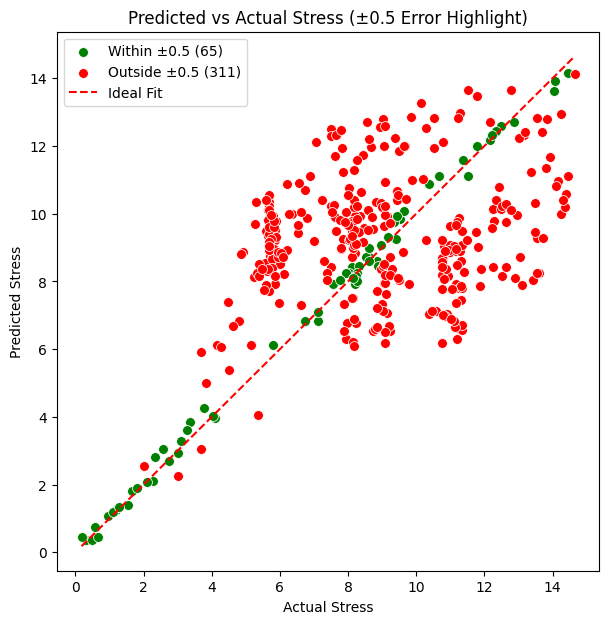

In [15]:
# === Residuals (error) ===
residuals = y_test - y_pred

# Masks
within_05 = abs(residuals) <= 0.5
outside_05 = abs(residuals) > 0.5

# Counts
count_within = within_05.sum()
count_outside = outside_05.sum()
total = len(residuals)

print("📊 Error Analysis:")
print(f"Within ±0.5: {count_within} points ({count_within/total:.2%})")
print(f"Outside ±0.5: {count_outside} points ({count_outside/total:.2%})")

# === Combined Plot ===
plt.figure(figsize=(7,7))

sns.scatterplot(
    x=y_test[within_05],
    y=y_pred[within_05],
    color="green", s=50, label=f"Within ±0.5 ({count_within})"
)

sns.scatterplot(
    x=y_test[outside_05],
    y=y_pred[outside_05],
    color="red", s=50, label=f"Outside ±0.5 ({count_outside})"
)

# Ideal line
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r', label="Ideal Fit")

plt.xlabel("Actual Stress")
plt.ylabel("Predicted Stress")
plt.title("Predicted vs Actual Stress (±0.5 Error Highlight)")
plt.legend()
plt.show()


In [16]:
import pandas as pd

# Residuals
residuals = y_test - y_pred
within_05 = abs(residuals) <= 0.5

# Create table of points within ±0.5
within_points = pd.DataFrame({
    "Actual_Stress": y_test[within_05],
    "Predicted_Stress": y_pred[within_05],
    "Residual": residuals[within_05]
}).reset_index(drop=True)

print("📊 Points within ±0.5 (showing first 20):")
print(within_points.head(20))

# Save full table
within_points.to_csv("within_05_points.csv", index=False)


📊 Points within ±0.5 (showing first 20):
    Actual_Stress  Predicted_Stress  Residual
0         8.11875          8.438360 -0.319610
1         8.32500          8.442594 -0.117594
2         9.52500          9.835094 -0.310094
3         8.02500          8.262063 -0.237063
4         5.80625          6.128031 -0.321781
5         1.66250          1.819281 -0.156781
6        10.38750         10.867688 -0.480188
7         1.20000          1.253719 -0.053719
8         9.33750          9.759188 -0.421688
9         2.73750          2.689719  0.047781
10       11.79375         11.990863 -0.197113
11        0.94375          1.076219 -0.132469
12        9.63125         10.085406 -0.454156
13        8.84375          8.591750  0.252000
14       12.87500         12.699969  0.175031
15        8.25000          8.248469  0.001531
16        2.27500          2.117952  0.157048
17       11.36250         11.578469 -0.215969
18       14.06875         13.932844  0.135906
19        7.93750          8.245694 -0.

Training on 65 points (within ±0.5)

Linear Results on 65 points:
R²: 0.8901916016192161
MAE: 1.2253917170587465


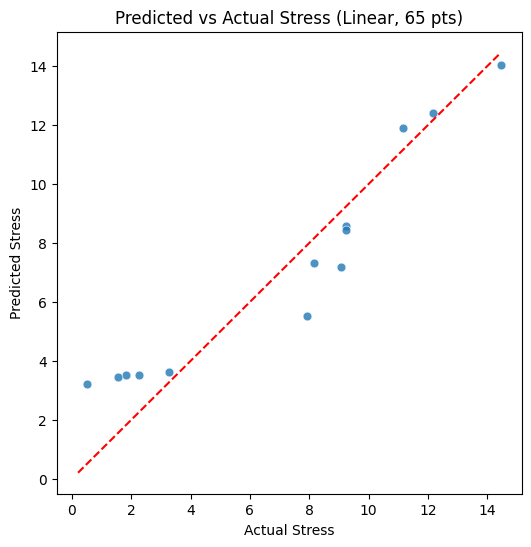

C:\Users\kisho\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


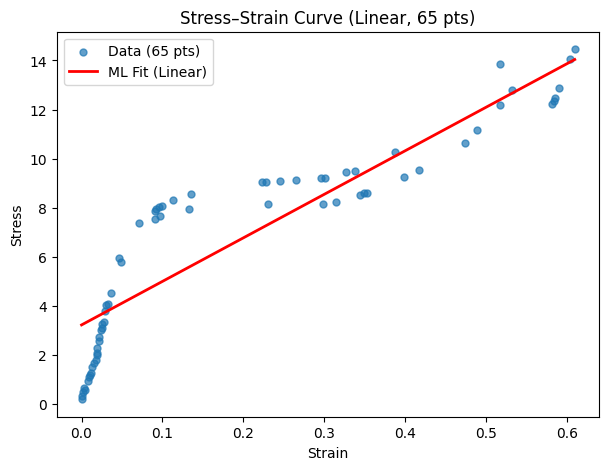


RandomForest Results on 65 points:
R²: 0.9837250093527345
MAE: 0.4396290865384672


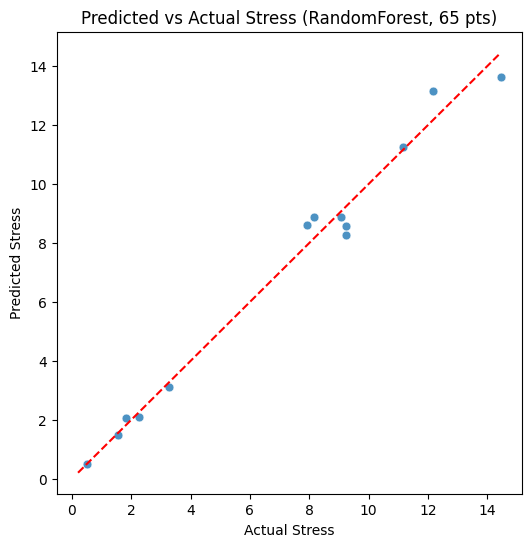

C:\Users\kisho\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


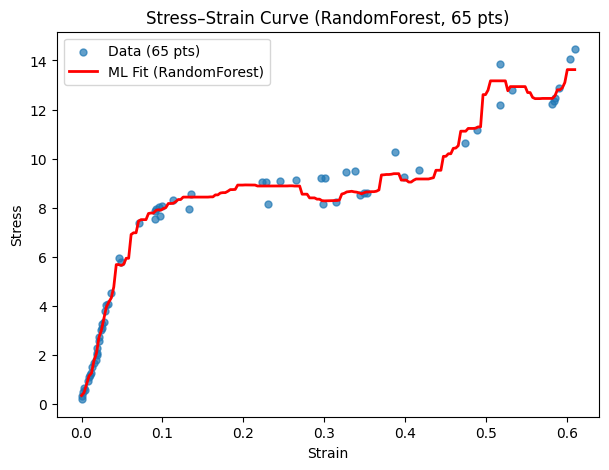

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# === 1. Filter points within ±0.5 ===
residuals = y_test - y_pred
within_05 = abs(residuals) <= 0.5

train_points = pd.DataFrame({
    "Strain": X_test["Strain"][within_05],
    "Density": X_test["Density"][within_05],
    "Group_FCC": X_test["Type_FCC"][within_05] if "Type_FCC" in X_test else 0,
    "Stress": y_test[within_05],
    "Predicted_Stress": y_pred[within_05]
}).reset_index(drop=True)

print(f"Training on {len(train_points)} points (within ±0.5)")

# === 2. Prepare features and target ===
X_65 = train_points[["Strain","Density","Group_FCC"]]
y_65 = train_points["Stress"]

# Train-test split
X_train,X_val,y_train,y_val = train_test_split(X_65,y_65,test_size=0.2,random_state=42)

# === 3. Fit ML models ===
models = {
    "Linear": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42)
}

for name, model in models.items():
    model.fit(X_train,y_train)
    y_pred_val = model.predict(X_val)

    print(f"\n{name} Results on 65 points:")
    print("R²:", r2_score(y_val,y_pred_val))
    print("MAE:", mean_absolute_error(y_val,y_pred_val))
 
    # === 4. Plot Predicted vs Actual Stress ===
    plt.figure(figsize=(6,6))
    sns.scatterplot(x=y_val, y=y_pred_val, s=40, alpha=0.8)
    plt.plot([y_65.min(),y_65.max()],[y_65.min(),y_65.max()],'--r')
    plt.xlabel("Actual Stress")
    plt.ylabel("Predicted Stress")
    plt.title(f"Predicted vs Actual Stress ({name}, 65 pts)")
    plt.show()

    # === 5. Stress–Strain curve plot ===
    strain_sorted = np.linspace(X_65["Strain"].min(), X_65["Strain"].max(), 200).reshape(-1,1)
    dummy_density = np.full_like(strain_sorted, X_65["Density"].mode()[0])
    dummy_type = np.full_like(strain_sorted, 0)  # assume FCC=0
    X_curve = np.hstack([strain_sorted, dummy_density, dummy_type])

    stress_curve = model.predict(X_curve)

    plt.figure(figsize=(7,5))
    plt.scatter(X_65["Strain"], y_65, s=25, alpha=0.7, label="Data (65 pts)")
    plt.plot(strain_sorted, stress_curve, 'r-', lw=2, label=f"ML Fit ({name})")
    plt.xlabel("Strain")
    plt.ylabel("Stress")
    plt.title(f"Stress–Strain Curve ({name}, 65 pts)")
    plt.legend()
    plt.savefig("65stressstrain curve.png", dpi=600, bbox_inches="tight")  # high resolution
    plt.show()


In [14]:
# === Extract Stress-Strain Points (65 pts within ±0.5) ===
residuals = y_test - y_pred
within_05 = abs(residuals) <= 0.5

stress_strain_points = pd.DataFrame({
    "Strain": X_test["Strain"][within_05],
    "Density": X_test["Density"][within_05],
    "Stress_Actual": y_test[within_05],
    "Stress_Predicted": y_pred[within_05],
    "Residual": residuals[within_05]
}).reset_index(drop=True)

print("📋 Stress–Strain Points (within ±0.5 error band):")
print(stress_strain_points.head(20))  # preview first 20

# Save complete table
stress_strain_points.to_csv("stress_strain_points_65.csv", index=False)


📋 Stress–Strain Points (within ±0.5 error band):
     Strain  Density  Stress_Actual  Stress_Predicted  Residual
0   0.51725       50       12.17500         12.607177 -0.432177
1   0.41750       40        9.52500          9.864156 -0.339156
2   0.04850       50        5.80625          6.075612 -0.269362
3   0.01500       50        1.66250          1.847125 -0.184625
4   0.01025       40        1.20000          1.272000 -0.072000
5   0.30150       50        9.22500          9.626979 -0.401979
6   0.02200       50        2.73750          3.010781 -0.273281
7   0.00800       40        0.94375          1.072563 -0.128813
8   0.59050       50       12.87500         12.818219  0.056781
9   0.01850       40        2.27500          2.382438 -0.107438
10  0.53275       40       12.78750         12.935284 -0.147784
11  0.60450       40       14.06875         13.918781  0.149969
12  0.13225       40        7.93750          8.072608 -0.135108
13  0.47350       40       10.65625         10.814052 -

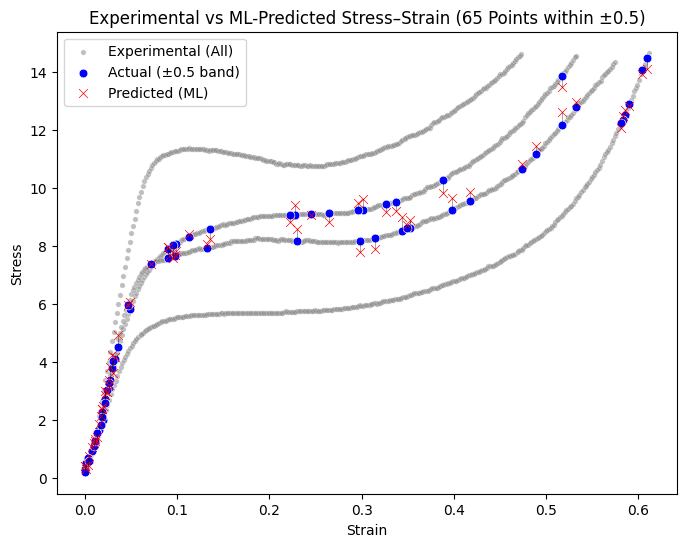

In [15]:
# === Plot Experimental vs ML-Predicted Stress–Strain Curve (65 points) ===

plt.figure(figsize=(8,6))

# Experimental curve (all data, actual stress-strain)
sns.scatterplot(data=stress_df, x="Strain", y="Stress", 
                s=15, alpha=0.5, label="Experimental (All)", color="gray")

# 65 predicted points
sns.scatterplot(x=stress_strain_points["Strain"], 
                y=stress_strain_points["Stress_Actual"],
                s=40, color="blue", marker="o", label="Actual (±0.5 band)")

sns.scatterplot(x=stress_strain_points["Strain"], 
                y=stress_strain_points["Stress_Predicted"],
                s=40, color="red", marker="x", label="Predicted (ML)")

# Connect predicted vs actual for 65 points (optional for clarity)
for i in range(len(stress_strain_points)):
    plt.plot([stress_strain_points["Strain"][i], stress_strain_points["Strain"][i]],
             [stress_strain_points["Stress_Actual"][i], stress_strain_points["Stress_Predicted"][i]],
             color="black", linewidth=0.5, alpha=0.5)

plt.xlabel("Strain")
plt.ylabel("Stress")
plt.title("Experimental vs ML-Predicted Stress–Strain (65 Points within ±0.5)")
plt.legend()
plt.grid(False)
plt.savefig("stress strain curve all.png", dpi=600, bbox_inches="tight")  # high resolution
plt.show()
